<a href="https://colab.research.google.com/github/kbdev20/Convolution_Crusaders/blob/main/Convolution_Crusaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setting Up the Project Environment:**

Welcome to the ship detection project! To ensure a smooth and consistent experience for all collaborators, we have organized all necessary data into a shared Google Drive folder. Here’s a step-by-step guide on setting up the project:

**Access the Shared Folder:**

Navigate to the shared folder dataa on Google Drive.
This folder contains all the required data and resources to run this project.
Add the Folder to Your Drive:

Right-click on the ‘dataa’ folder.
Select ‘Add shortcut to Drive’.
Choose ‘My Drive’ and click ‘Add Shortcut’.
Mount Google Drive in Colab:

In the first code cell of this notebook, run the script to mount your Google Drive.
Follow the on-screen instructions to authorize access.
Access the Dataset:

Once mounted, you can seamlessly access all files from the ‘dataa’ folder directly within this Colab notebook.
Now, you are all set! Each cell is well-documented to guide you through the various stages of the project. Execute the cells in sequence.

Link to the folder that contains the training data : https://drive.google.com/drive/folders/1nbnWUDDV68Y9KYsXB0Sjz1fs6-UJLqbu?usp=share_link

## File Extraction (Already Executed):

Note: This cell is for informational purposes and was executed once to extract the dataset files into the Google Drive folder. The dataset is now readily available in the ‘dataa’ directory for access and usage. There is no need to re-run this extraction process, and you can proceed to the subsequent cells for data exploration and model development.

In this cell, we mounted the Google Drive to the Colab environment and specified the zip file's path containing our dataset. We then extracted it to the designated directory, making the dataset ready for preprocessing and exploration.File Extraction (Already Executed):

Note: This cell is for informational purposes and was executed once to extract the dataset files into the Google Drive folder. The dataset is now readily available in the ‘dataa’ directory for access and usage. There is no need to re-run this extraction process, and you can proceed to the subsequent cells for data exploration and model development.

In this cell, we mounted the Google Drive to the Colab environment and specified the zip file's path containing our dataset. We then extracted it to the designated directory, making the dataset ready for preprocessing and exploration.

In [ ]:
"""
from google.colab import drive
import zipfile
import os


# Step 2: Specify the zip file name and extraction directory
zip_file_path = '/content/drive/MyDrive/dataa/airbus-ship-detection.zip'
extraction_directory = '/content/drive/MyDrive/dataa/'

# Ensure the extraction directory exists
if not os.path.exists(extraction_directory):
    os.makedirs(extraction_directory)

# Step 3: Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

print(f"Files extracted to {extraction_directory}")
"""
"""
from google.colab import drive
drive.mount('/content/drive')
"""

Files extracted to /content/drive/MyDrive/dataa/


## Data Loading and Preprocessing:

This cell is dedicated to loading and preprocessing the data. We’re starting by loading an RLE-encoded CSV file. The RLE (Run Length Encoding) is then decoded to binary masks. These binary masks are further converted to YOLO (You Only Look Once) format (x,y,w,h) bounding boxes. This conversion facilitates the easy utilization of the data for object detection tasks, particularly with YOLO architecture.

In [ ]:
import pandas as pd
import numpy as np
from skimage.measure import label, regionprops

# Load the RLE-encoded CSV
file_path = '/content/drive/MyDrive/dataa/train_ship_segmentations_v2.csv'
df = pd.read_csv(file_path).dropna()  # dropna() to remove rows with NaN values

# Function to decode RLE
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

# Function to convert binary mask to YOLO format bounding box
def mask_to_yolo_bbox(mask):
    labeled = label(mask)
    props = regionprops(labeled)
    if not props:
        return None
    y1, x1, y2, x2 = props[0].bbox
    height, width = mask.shape
    x_center = (x1 + x2) / 2 / width
    y_center = (y1 + y2) / 2 / height
    bbox_width = (x2 - x1) / width
    bbox_height = (y2 - y1) / height
    return [x_center, y_center, bbox_width, bbox_height]

# Apply the conversions
df['bbox'] = df['EncodedPixels'].apply(lambda x: mask_to_yolo_bbox(rle_decode(x)))

# Remove rows with None values (if any)
df = df.dropna()

# Create a new DataFrame with YOLO format annotations
yolo_df = pd.DataFrame()
yolo_df['ImageId'] = df['ImageId']
yolo_df[['x_center', 'y_center', 'width', 'height']] = pd.DataFrame(df['bbox'].tolist(), index=df.index)

# Print the new DataFrame
print(yolo_df.head())



         ImageId  x_center  y_center     width    height
2  000155de5.jpg  0.515625  0.628906  0.135417  0.046875
3  000194a2d.jpg  0.625651  0.386719  0.029948  0.026042
4  000194a2d.jpg  0.098958  0.496745  0.023438  0.011719
5  000194a2d.jpg  0.367188  0.233724  0.062500  0.014323
6  000194a2d.jpg  0.098307  0.503255  0.009115  0.001302


In [ ]:
!pip install scikit-learn


## Splitting the Dataset into Training, Validation, and Test Sets:

Dataset splitting is a crucial step in preparing the data for training and evaluation. In this cell, we are dividing the dataset into training, validation, and testing sets. The sklearn's train_test_split function is handy for this purpose. We're allocating 70% of the data to the training set, and the remaining 30% is split equally between the validation and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming yolo_df is your DataFrame and it's already defined and filled with your data
# We'll split it into training, validation, and test sets

# First, let's split the data into training (70%) and temp (30%)
train_df, temp_df = train_test_split(yolo_df, test_size=0.3, random_state=42)

# Then, let's split the temp data into validation (50%) and test (50%)
# So, validation and test sets will each be 15% of the original data
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Print the shapes of the datasets
print(f"Train: {train_df.shape}, Validation: {val_df.shape}, Test: {test_df.shape}")


Train: (57206, 5), Validation: (12258, 5), Test: (12259, 5)


## Visualizing Images with Bounding Boxes:

Visualization aids in understanding the data better. In this cell, we’re visualizing the first few images along with their corresponding bounding boxes. The bounding boxes are in YOLO format, and we are converting them to matplotlib format for visualization. This step provides insights into how well the ships are encapsulated within the bounding boxes.

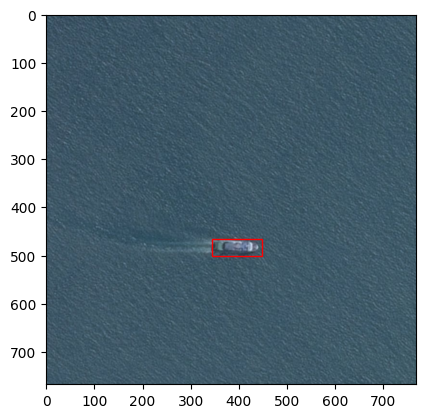

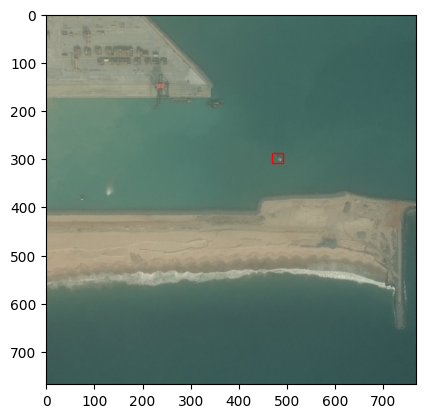

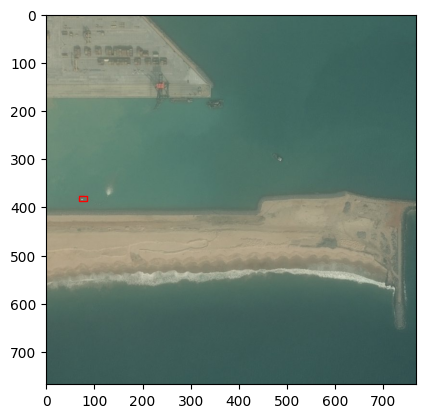

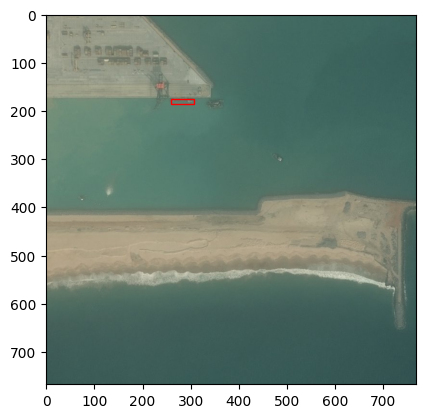

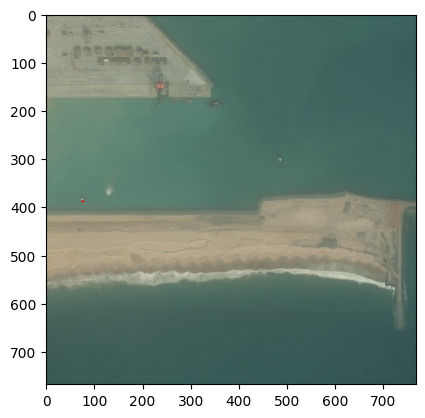

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Assuming yolo_df is your DataFrame with ['ImageId', 'x_center', 'y_center', 'width', 'height'] columns
# and it's already defined and filled with your data

# Directory containing the images
image_dir = '/content/drive/MyDrive/dataa/train_v2/'

# Function to convert YOLO format bounding box to matplotlib format [x, y, width, height]
def yolo_to_matplotlib_bbox(yolo_bbox, image_shape):
    x_center, y_center, width, height = yolo_bbox
    x_center *= image_shape[1]
    y_center *= image_shape[0]
    width *= image_shape[1]
    height *= image_shape[0]
    x = x_center - width / 2
    y = y_center - height / 2
    return [x, y, width, height]

# Plot the first few images with bounding boxes
num_images_to_plot = 5
unique_image_ids = yolo_df['ImageId'].unique()

for image_id in unique_image_ids[:num_images_to_plot]:
    image_path = image_dir + image_id
    image = Image.open(image_path)
    image_shape = image.size

    # Create a matplotlib figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Get all rows with the current image_id
    rows = yolo_df[yolo_df['ImageId'] == image_id]

    # Draw all bounding boxes for the current image
    for _, row in rows.iterrows():
        yolo_bbox = [row['x_center'], row['y_center'], row['width'], row['height']]
        x, y, width, height = yolo_to_matplotlib_bbox(yolo_bbox, image_shape)
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Show the plot
    plt.show()



## Computing Image and Ship Counts:

Here, we’re computing and displaying the total number of images, the count of images containing ships, and the average number of ships per image. These statistics offer a glimpse into the distribution and frequency of ships across the dataset.

In [ ]:
# Total number of images
total_images = yolo_df['ImageId'].nunique()

# Number of images containing ships
images_with_ships = yolo_df[yolo_df[['x_center', 'y_center', 'width', 'height']].notnull().all(axis=1)]['ImageId'].nunique()

# Average number of ships per image
avg_ships_per_image = yolo_df.groupby('ImageId').size().mean()

print(f"Total Images: {total_images}")
print(f"Images with Ships: {images_with_ships}")
print(f"Average Ships per Image: {avg_ships_per_image}")


##Analyzing the Sizes of Bounding Boxes:

The size of the bounding boxes can vary, indicating the varying sizes of ships in the images. In this cell, we're computing the area of each bounding box and plotting a histogram to visualize this variation. It helps us grasp the diversity in ship sizes present in the dataset.



In [ ]:
# Compute area of bounding boxes
yolo_df['bbox_area'] = yolo_df['width'] * yolo_df['height']

# Plot histogram of bounding box areas
plt.hist(yolo_df['bbox_area'].dropna(), bins=30, edgecolor='k')
plt.title('Bounding Box Size Distribution')
plt.xlabel('Bounding Box Area')
plt.ylabel('Count')
plt.show()


## Examining the Positions of Bounding Boxes:

The position of ships in the images can provide valuable insights. We’re generating a scatter plot to visualize the positions of bounding box centers. It highlights the common regions within images where ships are frequently located.

In [ ]:
# Scatter plot of bounding box centers
plt.scatter(yolo_df['x_center'], yolo_df['y_center'], alpha=0.2)
plt.title('Bounding Box Center Positions')
plt.xlabel('X Center')
plt.ylabel('Y Center')
plt.grid(True)
plt.show()


## Identifying Missing Values:

We are checking for any missing values in our dataset. Depending on the extent and pattern of missing values, subsequent preprocessing steps like removal can be decided.

In [ ]:
# Check for missing values
missing_values = yolo_df.isnull().sum()

# Display missing values count per column
print(f"Missing Values Count:\n{missing_values}")


## Inspecting Image Resolutions:

Here, we are extracting and printing out the resolutions of all images in the dataset. This step helps in understanding the diversity in image resolutions and is instrumental in deciding the input resolution for the model during the training phase.

In [ ]:
from PIL import Image
import os

image_dir = '/content/drive/MyDrive/dataa/train_v2'  # Replace with your actual image directory path
image_resolutions = [Image.open(os.path.join(image_dir, img)).size for img in os.listdir(image_dir) if img.endswith('.jpg')]

print(set(image_resolutions))